<a href="https://colab.research.google.com/github/Nexx136/sandbox/blob/master/rl_week1_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#! pip install --upgrade ipykernel

In [2]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# 0. Инициализация среды и ее свойства

Посмотрим как выглядит среда, какую в среднем награду получает агент и сколько длится эпизод. После оптимизации награда должна стать больше, а длительность меньше

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


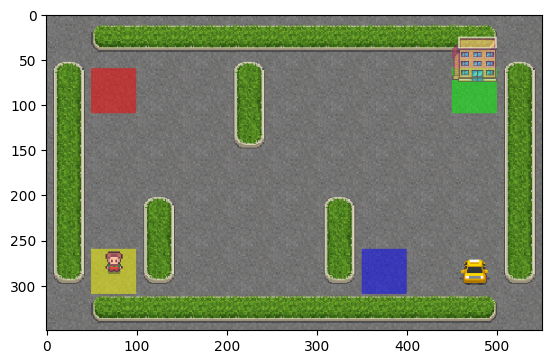

In [3]:
env = gym.make('Taxi-v3')
render = lambda : plt.imshow(env.render(mode='rgb_array'))
env.reset()
render()

In [4]:
env.action_space

Discrete(6)


    

```
такси может делать такие действия:
    0: move south
    1: move north
    2: move east
    3: move west
    4: pickup passenger
    5: drop off passenger
```




In [5]:
print(f' такси может принимать {env.observation_space} состояний ')

 такси может принимать Discrete(500) состояний 


# 1. Задание 1. Оптимизация алгоритма методом кросс-энтропии

## 1.1 сбор  статистики в случае случайного выбора действий

запустим 500 эпизодов чтобы посмотреть на среднююю длительность и награду. Далее мы эти данные для обучения использовать не будем

In [6]:
%%time
rewards = []
steps = []
for _ in range(500):
    done = False
    num_steps = 0
    total_reward = 0
    env.reset()
    while not done:
        action = np.random.choice(6, size=1)[0]
        next_state, reward, done, info = env.step(action)
        num_steps += 1
        total_reward += reward
    rewards.append(total_reward)
    steps.append(num_steps)

CPU times: user 8.05 s, sys: 171 ms, total: 8.22 s
Wall time: 12.9 s


In [7]:
print(f'''0.90 - 0.99 quantiles for reward:
0.90 :{np.quantile(rewards, 0.9)},
0.95 :{np.quantile(rewards, 0.95)},
0.975:{np.quantile(rewards, 0.975)},
0.99 :{np.quantile(rewards, 0.99)},
on average we get reward: {np.mean(rewards)} with {np.mean(num_steps)} steps.
''')

0.90 - 0.99 quantiles for reward: 
0.90 :-686.0,
0.95 :-640.5500000000004, 
0.975:-502.85000000000105, 
0.99 :-337.39000000000055,
on average we get reward: -770.082 with 82.0 steps.



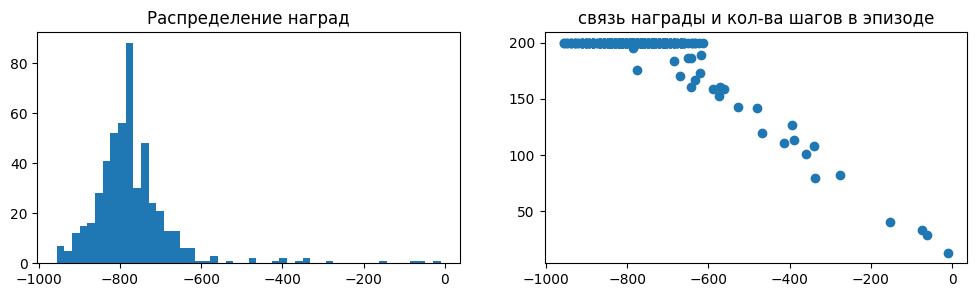

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))
ax[0].hist(rewards, bins=50)
ax[0].set_title('Распределение наград')
ax[1].scatter(rewards, steps)
ax[1].set_title('связь награды и кол-ва шагов в эпизоде');

## 1.2 метод кросс-энтропии для разных значений гиперпараметров

Найдем наилучшие значения гиперпараметров, при которых в среднем будем получать не отрицательный reward. Перебирать будем значения:


*   q = [0.7, 0.8, 0.85, 0.9, 0.95, 0.99]
*   trajectory_n (кол-во эпизодов в итерации) = [20, 50] + попробуем вариант с апдейтом политики после каждого элитного эпизода

Лучшим будем считать тот вариант, который будет приносить не отрицательную награду за наименьшее число шагов. остановимся, когда среднее по последним trajectory_n будет >=0






определим вспомогательные функции:

In [9]:
def update_strategy(cool_model:np.array, s:list):
    '''
        функция  принимает на вход матрицу для принятия решения о действии cool_model и апдейтит ее значения по переданному эпизоду s
    '''
    for s_i in range(len(curr_strategy)):
        cool_model[curr_strategy[s_i][0], curr_strategy[s_i][1]] += 1
    return cool_model

In [12]:
q = [0.7, 0.8, 0.85, 0.9, 0.95, 0.99]
trajectory = [1, 20, 50]
logs = []
n_states, n_actions = 500, 6
iteration_n0 = 100

for q_i in q:
    for t in trajectory:
        mean_reward = - 1000
        thres = -1000
        cool_model = np.ones((n_states, n_actions))
        n_updated = 0
        if t==1:
            iteration_n = iteration_n0 * trajectory[2]
        else:
            iteration_n = iteration_n0
        n_episodes = 0
        for _ in range(iteration_n):

            trajectory_stats = []

            for t_i in range(t):
                n_steps = 0
                trajectory_reward = 0
                done=False
                curr_strategy = []
                state = env.reset()
                while not done:
                    action = np.random.choice(6, size=1, p=cool_model[state, :] / np.sum(cool_model[state, :] ))[0]
                    next_state, reward, done, info = env.step(action)
                    curr_strategy.append([state, action, reward])
                    state = next_state
                    trajectory_reward += reward
                    n_steps += 1

                if t == 1:
                    if trajectory_reward>=thres:
                        cool_model = update_strategy(cool_model, curr_strategy)
                        try:
                            thres = np.quantile([l_i[1] for l in logs for l_i in l], q_i)
                            n_updated += 1
                        except IndexError:
                            pass
                n_episodes += 1
                trajectory_stats.append([n_steps,  trajectory_reward,  thres, q_i, t, curr_strategy, _, n_episodes])

            if t >1:
                for t_i in trajectory_stats:
                    if  t_i[1]>thres:
                        cool_model = update_strategy(cool_model, t_i[2])
                        n_updated += 1


            mean_reward = np.mean([c[1] for c in trajectory_stats])
            new_thres = np.quantile([c[1] for c in trajectory_stats], q_i)
            if t>1 and new_thres>thres:
                thres = new_thres
            logs.append(trajectory_stats)

            if n_episodes % 500 ==0:
                print(q_i, t, thres, n_updated, n_episodes)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.7 1 -596.0 249 500
0.7 1 -524.0 499 1000
0.7 1 -473.3000000000004 747 1500
0.7 1 -448.0 963 2000
0.7 1 -416.0 1192 2500
0.7 1 -389.0 1420 3000
0.7 1 -370.0 1634 3500
0.7 1 -351.0 1854 4000
0.7 1 -337.0 2067 4500
0.7 1 -322.0 2292 5000
0.7 20 -587.9000000000001 128 500
0.7 20 -587.9000000000001 217 1000
0.7 20 -413.3 283 1500
0.7 20 -404.3 349 2000
0.7 50 -722.0 163 500
0.7 50 -722.0 249 1000
0.7 50 -680.5 353 1500
0.7 50 -680.5 451 2000
0.7 50 -680.5 556 2500
0.7 50 -680.5 659 3000
0.7 50 -657.2 761 3500
0.7 50 -641.0 847 4000
0.7 50 -641.0 909 4500
0.7 50 -641.0 1002 5000
0.8 1 -395.0 99 500
0.8 1 -367.0 420 1000
0.8 1 -332.0 825 1500
0.8 1 -301.0 1229 2000
0.8 1 -274.0 1637 2500
0.8 1 -253.0 2034 3000
0.8 1 -234.0 2416 3500
0.8 1 -217.0 2791 4000
0.8 1 -205.0 3149 4500
0.8 1 -191.0 3505 5000
0.8 20 -650.0 87 500
0.8 20 -600.1999999999999 130 1000
0.8 20 -600.1999999999999 149 1500
0.8 20 -600.1999999999999 171 2000
0.8 50 -492.79999999999956 145 500
0.8 50 -350.0 216 1000
0.8 50 -3

# 2.0 добавляем laplace smoothing и policу smoothing

In [89]:
def update_strategy_with_laplace(cool_model:np.array, s:list, lambda=0.5):
    for s_i in range(len(curr_strategy)):
        cool_model[curr_strategy[s_i][0], curr_strategy[s_i][1]] += 1
        cool_model[curr_strategy[s_i], :] += lambda
    return cool_model

[200,
 -731,
 -1000,
 [[9, 4, -10],
  [9, 2, -1],
  [9, 2, -1],
  [9, 5, -10],
  [9, 1, -1],
  [9, 0, -1],
  [9, 1, -1],
  [9, 2, -1],
  [9, 3, -1],
  [9, 2, -1],
  [9, 3, -1],
  [9, 5, -10],
  [9, 4, -10],
  [9, 3, -1],
  [9, 2, -1],
  [9, 0, -1],
  [9, 3, -1],
  [9, 0, -1],
  [9, 3, -1],
  [9, 2, -1],
  [9, 4, -10],
  [9, 0, -1],
  [9, 3, -1],
  [9, 3, -1],
  [9, 0, -1],
  [9, 5, -10],
  [9, 0, -1],
  [9, 4, -10],
  [9, 2, -1],
  [9, 5, -10],
  [9, 0, -1],
  [9, 4, -10],
  [9, 2, -1],
  [9, 1, -1],
  [9, 4, -10],
  [9, 4, -10],
  [9, 1, -1],
  [9, 3, -1],
  [9, 3, -1],
  [9, 3, -1],
  [9, 5, -10],
  [9, 4, -10],
  [9, 0, -1],
  [9, 0, -1],
  [9, 2, -1],
  [9, 2, -1],
  [9, 1, -1],
  [9, 0, -1],
  [9, 4, -1],
  [9, 4, -10],
  [9, 2, -1],
  [9, 1, -1],
  [9, 2, -1],
  [9, 5, -10],
  [9, 5, -10],
  [9, 3, -1],
  [9, 1, -1],
  [9, 4, -10],
  [9, 0, -1],
  [9, 3, -1],
  [9, 2, -1],
  [9, 3, -1],
  [9, 2, -1],
  [9, 0, -1],
  [9, 4, -10],
  [9, 5, -1],
  [9, 2, -1],
  [9, 5, -10],
  [9, 0,

In [16]:
def update_strategy_with_policy(cool_model:np.array, s:list, lambda=0.5):
    for s_i in range(len(curr_strategy)):
      prev_model = cool_model[curr_strategy[s_i], :].copy()
      new_model = cool_model[curr_strategy[s_i][0], curr_strategy[s_i][1]] + 1
      cool_model[curr_strategy[s_i], :] = lambda * new_model + (1 - lambda) * prev_model
    return cool_model

[]

In [79]:
logs[1]

[1, 0, -677.0, -794, 200]

инициализируем cool_model по эпизодам с высоким reward. если фактический reward будет выше threshold, тогда пересчитываем cool_model, и со следующего эпизода выбираем события из апдейтнутой  cool_model

In [10]:
def update_strategy(cool_model:np.array, s:list):
    '''
        функция  принимает на вход матрицу для принятия решения о действии cool_model и апдейтит ее значения по переданному эпизоду s
    '''
    for s_i in range(len(curr_strategy)):
        cool_model[curr_strategy[s_i][0], curr_strategy[s_i][1]] += 1
    return cool_model

замерим, сколько раз удалось проапдейтить стратегии, сколько длится эпизод после каждого апдейта, насколько сокращается время между апдейтами эпизода, как улучшается средний reward по эпизодам

In [111]:
logs = []
rewards_train = rewards.copy()
n_updated = 0
for i in range(100):
    thres = np.quantile(rewards_train, 0.90)
    curr_strategy = []
    total_reward = 0
    n_steps = 0
    done = False
    state = env.reset()
    while not done:
        action = np.random.choice(6, size=1, p=cool_model[state, :] / np.sum(cool_model[state, :] ))[0]
        next_state, reward, done, info = env.step(action)
        curr_strategy.append([state, action, reward])
        total_reward += reward
        n_steps += 1
        state = next_state
    if  total_reward>thres:
        cool_model = update_strategy(cool_model, curr_strategy)
        n_updated += 1
        rewards_train.append(total_reward)
    logs.append([i, n_updated, thres, total_reward, n_steps])

In [112]:
df_res = pd.DataFrame(logs, columns=['n_iter', 'n_updated', 'thres', 'avg_reward', 'n_steps'])

<Axes: >

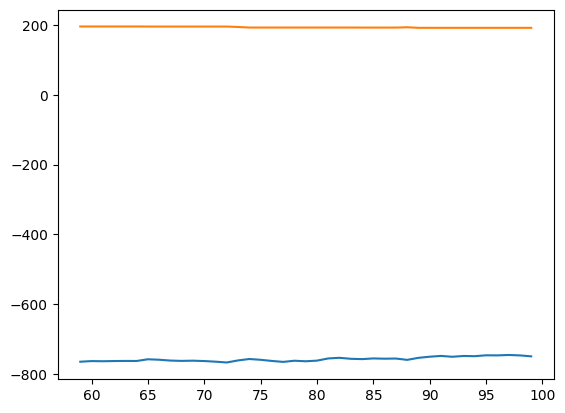

In [113]:
df_res['avg_reward'].rolling(60).mean().plot()
df_res['n_steps'].rolling(60).mean().plot()

In [14]:
print(f'''95% - 99 quantiles for reward: {np.quantile(rewards_train, 0.9)}, {np.quantile(rewards_train, 0.95)}, {np.quantile(rewards_train, 0.975)}, {np.quantile(rewards_train, 0.99)},
on average we get reward: {np.mean(rewards_train)} with {np.mean(num_steps)} steps.
''')

95% - 99 quantiles for reward: -641.0, -442.2000000000003, -307.5249999999999, -203.23000000000002,
on average we get reward: -749.7099236641221 with 200.0 steps.



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [114]:
df_res.groupby('n_updated').mean()

,n_iter,thres,avg_reward,n_steps
n_updated,,,,
0,3.0,-677.000,-800.428571,200.000000
1,9.5,-677.000,-759.000000,200.000000
2,13.0,-677.000,-489.000000,123.000000
3,14.0,-677.000,-659.000000,200.000000
4,15.5,-668.900,-677.000000,200.000000
5,22.0,-668.000,-765.363636,200.000000
6,35.0,-668.000,-790.866667,196.466667
7,46.5,-668.000,-779.375000,200.000000
8,53.0,-668.000,-765.800000,194.000000


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# 4.0 код из семинара

In [115]:
import gym
#import gym_maze
import numpy as np
import random
import time


# env = gym.make('maze-sample-5x5-v0')
env = gym.make('Taxi-v3')
state_n = 500
action_n = 6


class RandomAgent():
    def __init__(self, action_n):
        self.action_n = action_n

    def get_action(self, state):
        action = np.random.randint(self.action_n)
        return action


class CrossEntropyAgent():
    def __init__(self, state_n, action_n):
        self.state_n = state_n
        self.action_n = action_n
        self.model = np.ones((self.state_n, self.action_n)) / self.action_n

    def get_action(self, state):
        action = np.random.choice(np.arange(self.action_n), p=self.model[state])
        return int(action)

    def fit(self, elite_trajectories):
        new_model = np.zeros((self.state_n, self.action_n))
        for trajectory in elite_trajectories:
            for state, action in zip(trajectory['states'], trajectory['actions']):
                new_model[state][action] += 1

        for state in range(self.state_n):
            if np.sum(new_model[state]) > 0:
                new_model[state] /= np.sum(new_model[state])
            else:
                new_model[state] = self.model[state].copy()

        self.model = new_model
        return None


def get_state(obs):
#    return int(np.sqrt(state_n) * obs[0] + obs[1])
    return obs


def get_trajectory(env, agent, max_len=1000, visualize=False):
    trajectory = {'states': [], 'actions': [], 'rewards': []}

    state = env.reset()
#    state = get_state(obs)

    for _ in range(max_len):
        trajectory['states'].append(state)

        action = agent.get_action(state)
        trajectory['actions'].append(action)

        obs, reward, done, _ = env.step(action)
        trajectory['rewards'].append(reward)

        state = get_state(obs)

        if visualize:
            time.sleep(0.5)
            env.render()

        if done:
            break

    return trajectory


agent = CrossEntropyAgent(state_n, action_n)
q_param = 0.9
iteration_n = 100
trajectory_n = 50

for iteration in range(iteration_n):

    #policy evaluation
    trajectories = [get_trajectory(env, agent) for _ in range(trajectory_n)]
    total_rewards = [np.sum(trajectory['rewards']) for trajectory in trajectories]
    print('iteration:', iteration, 'mean total reward:', np.mean(total_rewards))

    #policy improvement
    quantile = np.quantile(total_rewards, q_param)
    elite_trajectories = []
    for trajectory in trajectories:
        total_reward = np.sum(trajectory['rewards'])
        if total_reward > quantile:
            elite_trajectories.append(trajectory)

    agent.fit(elite_trajectories)

trajectory = get_trajectory(env, agent, max_len=100, visualize=False)
ts = [get_trajectory(env, agent, max_len=100, visualize=False) for _ in range(10) ]
print('total reward:', sum(trajectory['rewards']))
#print('model:')
#print(agent.model)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


iteration: 0 mean total reward: -770.32
iteration: 1 mean total reward: -677.88
iteration: 2 mean total reward: -511.34
iteration: 3 mean total reward: -498.32
iteration: 4 mean total reward: -549.86
iteration: 5 mean total reward: -512.98
iteration: 6 mean total reward: -575.02
iteration: 7 mean total reward: -502.3
iteration: 8 mean total reward: -522.08
iteration: 9 mean total reward: -372.04
iteration: 10 mean total reward: -491.0
iteration: 11 mean total reward: -503.3
iteration: 12 mean total reward: -548.36
iteration: 13 mean total reward: -525.64
iteration: 14 mean total reward: -592.42
iteration: 15 mean total reward: -458.76
iteration: 16 mean total reward: -620.98
iteration: 17 mean total reward: -425.22
iteration: 18 mean total reward: -453.44
iteration: 19 mean total reward: -415.52
iteration: 20 mean total reward: -574.24
iteration: 21 mean total reward: -430.98
iteration: 22 mean total reward: -416.14
iteration: 23 mean total reward: -456.52
iteration: 24 mean total rewa

In [17]:
agent.model.shape, agent.action_n

((500, 6), 6)

In [18]:
state = env.reset()

In [19]:
t = get_trajectory(env, agent)

In [20]:
sum(t['rewards'])

5

In [21]:
next_state, reward, done, info = env.step(action)

In [22]:
agent.model


array([[0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667],
       [0.        , 0.        , 0.        , 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 1.        ,
        0.        ],
       ...,
       [0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667]])

In [23]:
env = gym.wrappers.Monitor(env, ',/video', forse=True)

AttributeError: ignored

In [ ]:
import pyvirtualdisplay
_display = pyvirtualdisplay.Display(visible=False,size=(1400, 900))  # use False with Xvfb
_ = _display.start()
!echo $DISPLAY

In [ ]:
import gym
import matplotlib.pyplot as plt
import numpy as np
from IPython import display

# Новый раздел

# Новый раздел

In [ ]:
   display = Display(visible=0, size=(1400, 900))
    display.start()

    def show_video():
        mp4list = glob.glob('video/*.mp4')
        if len(mp4list) > 0:
            mp4 = mp4list[0]
            video = io.open(mp4, 'r+b').read()
            encoded = base64.b64encode(video)
            ipythondisplay.display(HTML(data='''<video alt="test" autoplay loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''.format(encoded.decode('ascii'))))
        else:
            print("Could not find video")

    def wrap_env(env):
        env = Monitor(env, './video', force=True)
        return env

In [ ]:
!apt-get install x11-utils > /dev/null 2>&1
!pip install pyglet > /dev/null 2>&1
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

In [ ]:
env = gym.make("CartPole-v0")
env.reset()
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

for i in range(50):
  action = env.action_space.sample()
  obs, reward, done, info = env.step(action)
  screen = env.render(mode='rgb_array')

  plt.imshow(screen)
  ipythondisplay.clear_output(wait=True)
  ipythondisplay.display(plt.gcf())

  if done:
    break

ipythondisplay.clear_output(wait=True)
env.close()